# Major / minor isoform comparision

Major isoform : the most abundant isoform of a gene

Minor isoforms : isoforms of a gene that are not the most abundant



In [1]:

import os

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from huvec_analysis import huvec_config # parameters for plotting

# All of the plots will go into the plots folder
plot_dir = 'plot'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
# All of the stats will go into a directory
stats_dir = 'stats'
if not os.path.exists(stats_dir):
    os.makedirs(stats_dir)

matplotlib.rc('font', **huvec_config.font)


In [2]:

# file path to sqanti info
sqanti_info_path = '../00_pre_analysis/sqanti_info/sqanti_info.tsv'

# Read in HUVEC isoform information (SQANTI) - pre-processed reference table 
sqanti_info = pd.read_table(sqanti_info_path)
sqanti_info = sqanti_info[sqanti_info['cpm']> 1]


## Major / Minor isoform analysis

In [3]:

def mask_first(x):
    result = np.ones_like(x)
    result[0] = 0
    return result
# get the major isoform 
def get_major_isoform(sqanti_info):
    major_isoform = sqanti_info \
        .sort_values(by = 'cpm', ascending = False) \
        .groupby(['gene'], as_index = False).first()
    return major_isoform

# get the minor isoforms 
def get_minor_isoforms(sqanti_info):
    mask = sqanti_info \
        .sort_values(by = 'cpm', ascending = False) \
        .groupby(['gene'])['gene'] \
            .transform(mask_first).astype(bool)
    minor_isoforms = sqanti_info.loc[mask]
    return minor_isoforms

# for cpm threshold of 1 or higher
cpm_threshold = 1
over_N_cpm = sqanti_info[sqanti_info['cpm'] >= cpm_threshold]
# only perform the analysis for which there are multiple isoform genes 
over_N_cpm = over_N_cpm.groupby('gene').filter(lambda x: len(x) >1)
# get the cpm fraction of each isoform by gene 
gene_cpms = over_N_cpm.groupby('gene')['cpm'].sum().reset_index()
gene_cpms.columns = ['gene', 'total_gene_cpm']
over_N_cpm = over_N_cpm.merge(gene_cpms, on ='gene', how='inner')
over_N_cpm['cpm_fraction'] = over_N_cpm['cpm']/over_N_cpm['total_gene_cpm']
major_isoform = get_major_isoform(over_N_cpm)
minor_isoforms = get_minor_isoforms(over_N_cpm)
# output the major and minor isofoem tables 
major_isoform.to_csv('stats/2_major_isoforms.csv')
minor_isoforms.to_csv('stats/2_minor_isoforms.csv')
# get the genes only expressing one isoform

# Find how many of the major isoforms are novel 
major_isform_novel = major_isoform[(major_isoform['cat']=='NIC') | (major_isoform['cat']=='NNC')]

# merge the major and minor isoforms onto the sqanti table to have a quick intermediate table of this informatio 
major_isoform['is_major_isoform'] = '1'
sqanti_info_merged = pd.merge(left= sqanti_info, right=major_isoform, left_on='pb_acc', right_on= 'pb_acc', how = 'outer')
sqanti_info_merged['is_major_isoform'] = sqanti_info_merged['is_major_isoform'].replace(np.nan,0)
sqanti_info_merged.to_csv('stats/2_sqanti_info_major_minor_isos.csv')


In [4]:

# Plot the minor isoforms abundances
def plot_genes_over_cpm_threshold(minor_isoforms): 
    fractional_abundance_file = 'stats/01_num_genes_w_minor_isoforms_above_threshold.tsv'
    with open(fractional_abundance_file, 'w') as ofile: 
        for cpm_thresh in np.arange(0, 0.6, 0.1):
            num_non_top = len(minor_isoforms[minor_isoforms['cpm_fraction'] > cpm_thresh]['gene'].unique())
            ofile.write(f'{cpm_thresh:.1f}\t{num_non_top}\n')
    # make a table of the minor fractional abundance and count of the isoforms at each farc abundannce threshold 
    frac = pd.read_table(fractional_abundance_file)
    frac.columns = ['Minor isoform fraction', "Number of transcript isoforms"]
    frac.dfi.export('plot/01_num_genes_w_minor_isoforms_at_diff_frac_abundance.png')
plot_genes_over_cpm_threshold(minor_isoforms)


[0411/102710.982450:INFO:headless_shell.cc(659)] Written to file /var/folders/wb/w94qkvl91k913tb6pyw_wp240000gn/T/tmpc5hoyzed/temp.png.


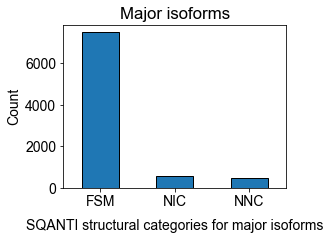

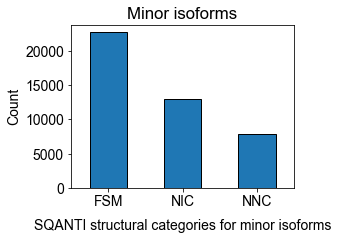

<Figure size 432x288 with 0 Axes>

In [5]:


# Plot the sqanti categories for the major and minor isoforms
def plot_major_minor_SQANTI_cats(major_isoform, minor_isoforms):
    # plot sqanti categories for major isoforms, minor (0.1 cpm+), and all minor
    # get group of major isoforms
    major_grp = major_isoform.groupby('cat').size()
    minor_grp = minor_isoforms.groupby('cat').size()
    # plot sqanti categories, broken down by major/minor isoform
    plt.clf()
    for (grp, name, title) in ((major_grp, 'major', 'Major isoforms'),
                            (minor_grp, 'minor', 'Minor isoforms')):
        categories = ['FSM','NIC','NNC']
        colors = [huvec_config.sqanti_colors[cat] for cat in categories]
        grp_noism = grp[categories]
        grp_noism.plot(kind='bar', figsize=(4,3), edgecolor='black', linewidth=1)
        plt.title(title)
        plt.xticks(rotation=0)
        plt.xlabel(f'SQANTI structural categories for {name} isoforms', labelpad=10)
        plt.ylabel('Count')
        plt.savefig(f'plot/02_bar_sqanti_cat_for_{name}_iso.pdf', bbox_inches='tight')
        plt.show()
        plt.clf()
        (grp_noism
            .reset_index()
            .rename(columns={'cat':'sqanti_cat', 0:'count'})
            .to_csv(f'stats/02_sqanti_cats_{name}_iso.tsv', sep='\t', index=None))
plot_major_minor_SQANTI_cats(major_isoform, minor_isoforms)


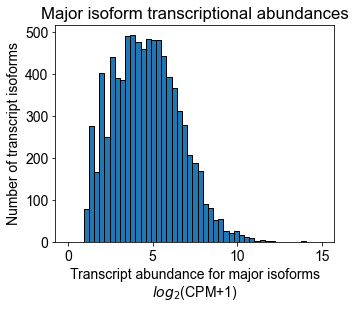

<Figure size 432x288 with 0 Axes>

In [6]:


# Plot the major isoform transcriptional abundances 
def plot_transcriptional_abundances_major_iso(major_isoform): 
    # make the bins for the histograms 
    bin_ranges = np.linspace(0, 15) 
    # major isoform transcriptional abundance distributions 
    fig, ax = plt.subplots(figsize=(5,4))
    major_isoform['log2cpm'] = np.log2(major_isoform['cpm'] + 1)
    major_isoform['log2cpm'].hist(bins=bin_ranges, edgecolor = 'black')
    ax.grid(False)
    plt.xlabel('Transcript abundance for major isoforms\n$log_2$(CPM+1)')
    plt.ylabel("Number of transcript isoforms")
    plt.title('Major isoform transcriptional abundances')
    plt.savefig('plot/03_hist_major_isoform_transcriptional_abundances.pdf', bbox_inches = 'tight')
    plt.show()
    plt.clf()
plot_transcriptional_abundances_major_iso(major_isoform)


<ipython-input-19-018da5c1e507>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  minor_isoforms['log2cpm']= np.log2(minor_isoforms['cpm'] + 1)


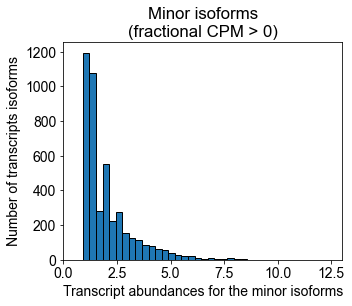

<ipython-input-19-018da5c1e507>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  minor_isoforms['log2cpm']= np.log2(minor_isoforms['cpm'] + 1)


<Figure size 432x288 with 0 Axes>

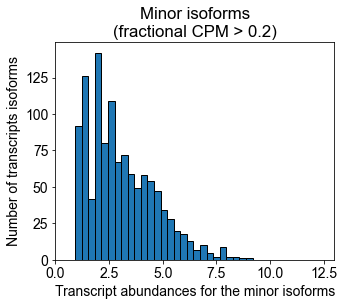

<Figure size 432x288 with 0 Axes>

In [19]:


# plot the transcriptional abundances for the minor isoforms 
def plot_transcriptional_abundances_minor_iso(minor_isoforms): 
    # make the bins for the hist
    bin_ranges = np.linspace(0,15)
    for cpm_frac in [0, 0.2]:
        fig, ax = plt.subplots(figsize=(5,4))
        minor_isoforms['log2cpm']= np.log2(minor_isoforms['cpm'] + 1)
        minor_isoforms[minor_isoforms['cpm_fraction'] > cpm_frac]['log2cpm'].hist(bins=bin_ranges, edgecolor = 'black')
        ax.grid(False)
        plt.xlabel("Transcript abundances for the minor isoforms")
        plt.ylabel('Number of transcripts isoforms')
        plt.xlim(0, 13)
        plt.title('Minor isoforms\n(fractional CPM > {})'.format(cpm_frac))
        plt.savefig(f'plot/04_hist_minor_isoforms_abundances_cpm_thresh_{cpm_frac}.pdf', bbox_inches = 'tight')
        plt.show()
        plt.clf()
plot_transcriptional_abundances_minor_iso(minor_isoforms)

#%%